## VarQBM

This Jupyter notebook is mostly the same as the one found in Leevi Lehtonen's Master's degree work in https://github.com/leevilehtonen/tfq-varqbm/tree/main, here only modified for plotting purposes.

In [1]:
import cirq
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import pandas as pd

from qite import QITE
from qbm import QBM
from circuit import build_ansatz, initialize_ansatz_symbols
from problem import build_ising_model_hamiltonian
from hamiltonian import Hamiltonian
from utils import evaluate_exact_state, plot_density_matrix_heatmap, get_ancillary_qubits, save_circuit_to_svg, circuit_to_state
from dataset import bars_and_stripes_probability, bars_and_stripes, samples_from_distribution, plot_dataset

2024-05-18 20:53:16.443994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-18 20:53:16.444019: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-18 20:53:21.327574: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-18 20:53:21.327608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (francesco-X1Y4): /proc/driver/nvidia/version does not exist
2024-05-18 20:53:21.328482: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2

## Define dataset

Define dataset, that is the bar and stripes on 2x2 grid (simplified by considering empty and fully filled as invalid values) 

In [2]:
p_data = tf.convert_to_tensor(
    bars_and_stripes_probability(bars_and_stripes(n=100000, no_fills_or_empties=True))
)
print(np.around(p_data.numpy(),2))

[0.   0.   0.   0.25 0.   0.25 0.   0.   0.   0.   0.25 0.   0.25 0.
 0.   0.  ]


In [3]:
example_BAS = bars_and_stripes(n=25,no_fills_or_empties=True)
plot_dataset(example_BAS, file_format="pdf", size=2, cmap=None, desc=None, shape=(5,5), sort=True, save=True, name='BAS_dataset', titles = False)

## Define Hamiltonian and qubits

Define Hamiltonian of which coefficients are to be trained so that the thermal state's sampling probabilties would be as close as possible to the data distribution

In [23]:
ising_model, problem_qubits = build_ising_model_hamiltonian(
    [4], transverse=None
)
ancillary_qubits = get_ancillary_qubits(problem_qubits)
qubits = [*problem_qubits, *ancillary_qubits]
initial_coefficients = tf.random.uniform(
    [len(ising_model)], minval=-1, maxval=1
)
hamiltonian = Hamiltonian(
    ising_model,
    coefficients=tf.Variable(
        tf.identity(initial_coefficients)
    ),
)
print(hamiltonian)

1.000*Z((0, 0))*Z((1, 0))+1.000*Z((0, 0))*Z((2, 0))+1.000*Z((0, 0))*Z((3, 0))+1.000*Z((1, 0))*Z((2, 0))+1.000*Z((1, 0))*Z((3, 0))+1.000*Z((2, 0))*Z((3, 0))+1.000*Z((0, 0))+1.000*Z((1, 0))+1.000*Z((2, 0))+1.000*Z((3, 0))
-0.883*Z((0, 0))*Z((1, 0))+0.887*Z((0, 0))*Z((2, 0))+0.227*Z((0, 0))*Z((3, 0))+0.769*Z((1, 0))*Z((2, 0))+0.206*Z((1, 0))*Z((3, 0))-0.234*Z((2, 0))*Z((3, 0))-0.326*Z((0, 0))-0.428*Z((1, 0))-0.221*Z((2, 0))+0.976*Z((3, 0))


## Define the quantum circuit

Define the quantum circuit that is used for VarQITE and the preparation of the thermal state

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


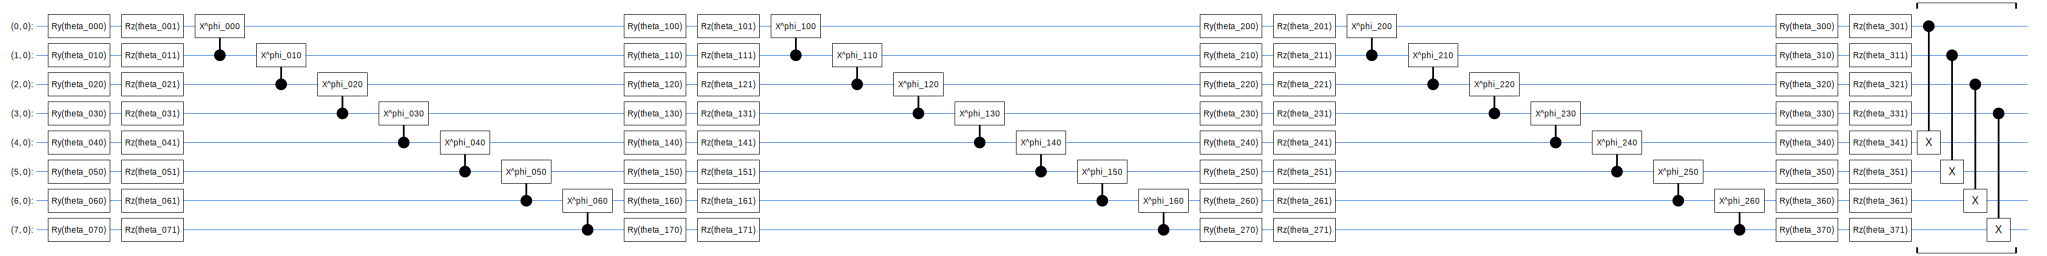

In [5]:
n_layers = 3
circuit, symbol_names = build_ansatz(qubits, n_layers=n_layers)
initial_symbol_values = initialize_ansatz_symbols(
    len(qubits), 
    n_layers=n_layers
)
from cirq.contrib.svg import SVGCircuit
SVGCircuit(circuit)

## Setup VarQBM model

Setup a VarQBM model using defaults and providing the circuit, the Hamiltonian, circuit symbols and their initial values, and the number of time steps to which the VarQITE evolution is split as part of VarQBM (higher value generally is more accurate but takes more time)

In [6]:
qbm = QBM(
    circuit,
    symbol_names,
    initial_symbol_values,
    hamiltonian,
    n_timesteps=40,
    verbose_qite=3,
)

## Run VarQBM training
Running VarQBM training gives us the Hamiltonian with trained coefficients, the final trained state in density matrix format, trained circuit symbol values and metrics from the training process. (Likely, this requires redesign for actual hardware, i.e. for the density matrix one could directly consider returning samples if possible.)

In [7]:
#trained_hamiltonian, trained_state, trained_symbol_values, metrics = qbm.train(p_data, epochs=40)

(To avoid running several hours, here's the result of one "succesful" run)

In [8]:

trained_hamiltonian_coefficients = [
    -0.13697385787963867,
    -0.15982627868652344,
    1.1702172756195068,
    2.6191375255584717,
    -0.29886317253112793,
    -0.29584717750549316,
    -0.07853007316589355,
    -0.2576768398284912,
    -0.2590906620025635,
    -0.014436483383178711
]
trained_hamiltonian = Hamiltonian(ising_model, trained_hamiltonian_coefficients)
# One can prepare the thermal state of the trained Hamiltonian again by running VarQITE
#trained_symbol_values, state = qbm.run_qite(trained_hamiltonian, skip_metrics=True)
trained_symbol_values = [
    -0.014642548747360706,
    -3.441415117322322e-07,
    -0.01728099398314953,
    -8.662656000524294e-06,
    -0.004501198884099722,
    1.1648027793853544e-05,
    0.2876802682876587,
    -0.00012912784586660564,
    -1.3544297627898771e-11,
    -6.415218933852884e-08,
    -1.2945443328415962e-11,
    -3.1357657803710026e-08,
    -1.0079138912377772e-11,
    -7.583848571357521e-08,
    -1.781818442792016e-11,
    -2.060415482674216e-07,
    -0.014686104841530323,
    -9.479756045038812e-06,
    -0.016323236748576164,
    1.5828969480935484e-05,
    0.041991300880908966,
    -0.00016045317170210183,
    0.07910387963056564,
    -0.0002838200598489493,
    -3.075627599824493e-11,
    -3.1359231655869735e-08,
    -1.2116604594658575e-11,
    -7.584274896998977e-08,
    -1.7822255823918276e-11,
    -2.5283253535235417e-07,
    -1.7819704045685114e-11,
    -2.0604063877271983e-07,
    -0.016164422035217285,
    2.3528562451247126e-05,
    0.009831184521317482,
    -0.0001395646104356274,
    -1.051080584526062,
    -0.00016350357327610254,
    0.015614356845617294,
    -0.00030664922087453306,
    2.5852771312617762e-11,
    -1.4341814846829948e-07,
    1.8851156746713116e-11,
    -1.1220399187550356e-07,
    1.2182884909228697e-11,
    1.3185865554987686e-07,
    1.2183080932981483e-11,
    1.3185872660415043e-07,
    1.578497290611267,
    -8.13862470749882e-07,
    1.565839171409607,
    -7.825872307876125e-05,
    1.509065866470337,
    -0.00017533988284412771,
    1.5611470937728882,
    -4.3912779801758006e-05,
    -5.514004183804211e-12,
    3.741260456990858e-08,
    3.3556379896992894e-11,
    1.1650548259467541e-07,
    4.171089515447868e-11,
    -5.5527948461531196e-08,
    4.2645778401684264e-12,
    -5.552934823072064e-08,
    0.999977171421051,
    0.9999960064888,
    0.999805212020874,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9999657273292542,
    0.9997722506523132,
    0.999398410320282,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9995574355125427,
    0.9996995329856873,
    0.999622642993927,
    1.0,
    1.0,
    1.0,
    1.0
]


## Pulling samples

Cirq and Tfq provides many different ways to get samples given the circuit, symbols and their values. One examples shown below which is easy but relies potentially non-optimized features.

### Tfq state layer to get probability distribution
Use ``circuit_to_state`` utility function which internally uses Tfq's State layer to get density matrix from which the probability distribution can be easilly acquired. Another way (potentially more "realistic") is to use Cirq's simulator to get samples from the problem qubits (i.e. tracing out the ancillary qubits). 

In [9]:
trained_symbol_values, state = qbm.run_qite(trained_hamiltonian, skip_metrics=True)

QITE:   0%|                                              | 0/40 [00:00<?, ?it/s]

QITE timestep   0: [energy = 0.000]


QITE:   2%|▉                                     | 1/40 [00:12<07:56, 12.21s/it]

QITE timestep   1: [energy = 0.000]


QITE:   5%|█▉                                    | 2/40 [00:24<07:53, 12.47s/it]

QITE timestep   2: [energy = -0.088]


QITE:   8%|██▊                                   | 3/40 [00:37<07:38, 12.40s/it]

QITE timestep   3: [energy = -0.175]


QITE:  10%|███▊                                  | 4/40 [00:49<07:18, 12.19s/it]

QITE timestep   4: [energy = -0.262]


QITE:  12%|████▊                                 | 5/40 [01:01<07:06, 12.18s/it]

QITE timestep   5: [energy = -0.348]


QITE:  15%|█████▋                                | 6/40 [01:14<07:11, 12.70s/it]

QITE timestep   6: [energy = -0.433]


QITE:  18%|██████▋                               | 7/40 [01:28<07:10, 13.04s/it]

QITE timestep   7: [energy = -0.518]


QITE:  20%|███████▌                              | 8/40 [01:43<07:11, 13.47s/it]

QITE timestep   8: [energy = -0.601]


QITE:  22%|████████▌                             | 9/40 [01:58<07:17, 14.13s/it]

QITE timestep   9: [energy = -0.683]


QITE:  25%|█████████▎                           | 10/40 [02:12<07:05, 14.19s/it]

QITE timestep  10: [energy = -0.764]


QITE:  28%|██████████▏                          | 11/40 [02:26<06:49, 14.12s/it]

QITE timestep  11: [energy = -0.844]


QITE:  30%|███████████                          | 12/40 [02:40<06:30, 13.94s/it]

QITE timestep  12: [energy = -0.923]


QITE:  32%|████████████                         | 13/40 [02:54<06:13, 13.85s/it]

QITE timestep  13: [energy = -1.001]


QITE:  35%|████████████▉                        | 14/40 [03:07<05:58, 13.77s/it]

QITE timestep  14: [energy = -1.077]


QITE:  38%|█████████████▉                       | 15/40 [03:21<05:42, 13.70s/it]

QITE timestep  15: [energy = -1.152]


QITE:  40%|██████████████▊                      | 16/40 [03:34<05:28, 13.68s/it]

QITE timestep  16: [energy = -1.225]


QITE:  42%|███████████████▋                     | 17/40 [03:48<05:12, 13.60s/it]

QITE timestep  17: [energy = -1.297]


QITE:  45%|████████████████▋                    | 18/40 [04:01<04:58, 13.56s/it]

QITE timestep  18: [energy = -1.368]


QITE:  48%|█████████████████▌                   | 19/40 [04:15<04:44, 13.53s/it]

QITE timestep  19: [energy = -1.437]


QITE:  50%|██████████████████▌                  | 20/40 [04:28<04:30, 13.54s/it]

QITE timestep  20: [energy = -1.504]


QITE:  52%|███████████████████▍                 | 21/40 [04:42<04:16, 13.52s/it]

QITE timestep  21: [energy = -1.570]


QITE:  55%|████████████████████▎                | 22/40 [04:55<04:02, 13.47s/it]

QITE timestep  22: [energy = -1.635]


QITE:  57%|█████████████████████▎               | 23/40 [05:09<03:48, 13.47s/it]

QITE timestep  23: [energy = -1.698]


QITE:  60%|██████████████████████▏              | 24/40 [05:22<03:35, 13.47s/it]

QITE timestep  24: [energy = -1.759]


QITE:  62%|███████████████████████▏             | 25/40 [05:47<04:12, 16.85s/it]

QITE timestep  25: [energy = -1.819]


QITE:  65%|████████████████████████             | 26/40 [06:00<03:41, 15.84s/it]

QITE timestep  26: [energy = -1.877]


QITE:  68%|████████████████████████▉            | 27/40 [06:15<03:20, 15.42s/it]

QITE timestep  27: [energy = -1.934]


QITE:  70%|█████████████████████████▉           | 28/40 [06:29<02:59, 14.99s/it]

QITE timestep  28: [energy = -1.989]


QITE:  72%|██████████████████████████▊          | 29/40 [06:43<02:44, 14.95s/it]

QITE timestep  29: [energy = -2.043]


QITE:  75%|███████████████████████████▊         | 30/40 [06:57<02:26, 14.65s/it]

QITE timestep  30: [energy = -2.095]


QITE:  78%|████████████████████████████▋        | 31/40 [07:12<02:11, 14.56s/it]

QITE timestep  31: [energy = -2.145]


QITE:  80%|█████████████████████████████▌       | 32/40 [07:26<01:54, 14.36s/it]

QITE timestep  32: [energy = -2.195]


QITE:  82%|██████████████████████████████▌      | 33/40 [07:40<01:41, 14.44s/it]

QITE timestep  33: [energy = -2.242]


QITE:  85%|███████████████████████████████▍     | 34/40 [07:55<01:26, 14.45s/it]

QITE timestep  34: [energy = -2.289]


QITE:  88%|████████████████████████████████▍    | 35/40 [08:09<01:11, 14.28s/it]

QITE timestep  35: [energy = -2.334]


QITE:  90%|█████████████████████████████████▎   | 36/40 [08:23<00:56, 14.23s/it]

QITE timestep  36: [energy = -2.377]


QITE:  92%|██████████████████████████████████▏  | 37/40 [08:37<00:42, 14.09s/it]

QITE timestep  37: [energy = -2.419]


QITE:  95%|███████████████████████████████████▏ | 38/40 [08:51<00:28, 14.13s/it]

QITE timestep  38: [energy = -2.460]


QITE:  98%|████████████████████████████████████ | 39/40 [09:05<00:14, 14.04s/it]

QITE timestep  39: [energy = -2.500]


QITE timestep  40: [energy = -2.538]


In [10]:
state = circuit_to_state(
    circuit,
    symbol_names,
    trained_symbol_values,
    list(range(len(problem_qubits))),
)
p_model = np.diag(state.numpy().real)

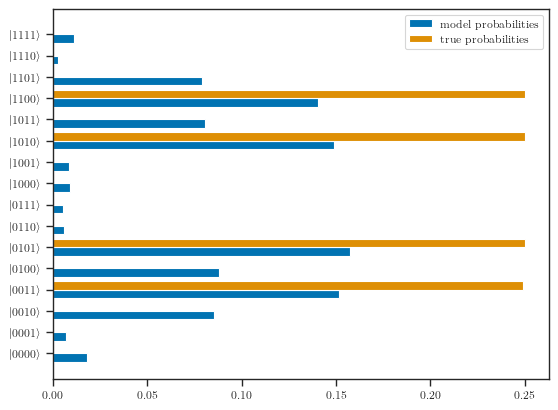

In [17]:
import matplotlib.pyplot as plt
labels = [ r'$|$'+ "{:04b}".format(i) + r'$\rangle$' for i in range(16)]
height = 0.40
plt.barh(labels, p_model, -height, align='edge', label='model probabilities')
plt.barh(labels, p_data, +height, align='edge', label='true probabilities')
plt.legend()
args = {"format": 'pdf', "bbox_inches": "tight"}
plt.savefig('probabilities.pdf', **args)
plt.show()
#Check https://stackoverflow.com/questions/5792728/how-to-plot-a-grouped-bar-chart-from-multiple-datasets

Draw samples from probability distribution

In [18]:
print(p_model)

[0.01815452 0.0069386  0.08539622 0.15182838 0.08826628 0.15718935
 0.00601087 0.00526609 0.00932413 0.00853491 0.14877054 0.08033546
 0.14069463 0.07905903 0.00292123 0.01130965]


In [22]:
plot_dataset(samples_from_distribution(p_model, n = 12), file_format="pdf", size = 2, save=True, sort=False, titles=True)

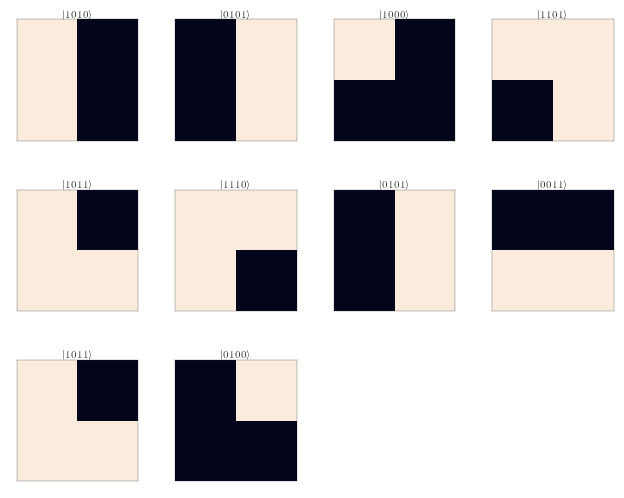

In [33]:
plot_dataset(samples_from_distribution(p_model, n = 10), file_format="png", size = 2, save=False, sort=False, titles=True)

As it is visible the model generates valid stripes but it also includes quite a lot of samples not beloging to bars and stripes. This clearly indicates that model was did not perform well enough given that the dataset is rather simple.